<a href="https://colab.research.google.com/github/decci027/datascience_a2/blob/main/Unit8ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 8 Exercises: The Art of BART

These exercises are grouped into two parts:

- Questions on the nature of decision trees, random forests, and BART models
- An oppurtunity to practice implementing and analyzing a BART model.

Enjoy!

## Bartian Theory

**Task1**:

Draw a decision tree--on a physical piece of paper--that predicts how much time you'll spend studying on a given day, using the amount of sleep you got the night before as a predictor.

If this seems to easy, then add another variable or two (test tomorrow? activity after school?), and/or increase the depth of your tree.

You do not have to show me or turn in your tree to earn credit for this question, although I would like to see your drawing.

**Task2**:

What is a decision tree? How do they work?

A decision tree is a flowchart-like diagram that maps out potential solutions or outcomes based on various conditions or decisions, providing a visual way to analyze and understand different and complex scenarios. It is mainly each node can have only one 'parent' node. There is a special node called the 'root' node, with no parents. Each layer of the tree sorts the predictor values into subsets of the predicted values

**Task3**:

What does the "depth" of a decision tree mean?

How do I know if a tree is too deep, or not deep enough?


The depth of a decision tree is the length of the longest path from the root node to a leaf node. A shallow tree has a lower depth, while a deep tree has a higher depth. A shallow tree may underfit the data, capturing too few patterns, while a deep tree may overfit the data, capturing noise in the training set

**Task4:**

How are BART models similar and different from a decision tree?

 BART uses a regularization prior that forces each tree to be able to explain only a limited subset of the relationships between the covariates and the predictor variable. However,

**Task5**:

Why would we use a BART model instead of a decision tree?

A BART model might be more optimal to chose instead of a decision tree because a BART model leverages the flexibility of decision trees while incorporating Bayesian priors to regularize and reduce overfitting, resulting in better generalization and uncertainty quantification. Even though the decision tree can be interpretable and flexible model, it is also prone to overfitting

## Bartian Penguins

**Task6**:

Create a BART model that uses flipper length, bill depth, and bill length to predict body mass in penguins, and make a ppc to check its fit

Code for loading the data is below. You'll need to do everything else yourself.

Remember to use my notes as a reference, and to copy and paste from them when it makes sense to.

Oh, and try a normal likelihood.

In [1]:
!pip install pymc-bart
!pip install preliz

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import preliz as pz
import seaborn as sns

In [3]:
from sklearn import tree

In [4]:
#drop the incomplete rows from the data
url="https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/penguins.csv"
penguins = pd.read_csv(url).dropna()

In [5]:
X = penguins[['flipper_length',
              'bill_depth',
              'bill_length',
]]
Y = penguins["body_mass"].to_numpy()

In [6]:
with pm.Model() as model_penguinR:
    s = pm.HalfNormal('s', 20)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y)
    idata_penguinR = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

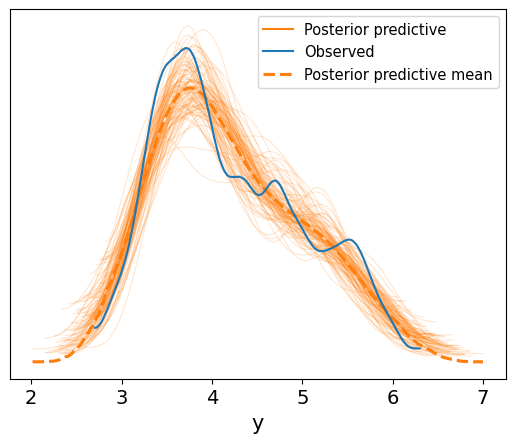

In [7]:
#generate the posterior predictive dist
pm.sample_posterior_predictive(idata_penguinR,model_penguinR, extend_inferencedata=True)
az.plot_ppc(idata_penguinR, num_pp_samples=100, colors=["C1", "C0", "C1"])

**Task7**:

Plot flipper length versus body mass,

and then plot the posterior predictve from the model over the data.
You're going to copy paste the plotting code from the notes, fyi.

In [8]:
X = penguins["flipper_length"].to_numpy().reshape(-1, 1)
Y = penguins["body_mass"].to_numpy()

In [9]:
with pm.Model() as model_penguin:
    s = pm.HalfNormal('s', 20)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y)
    idata_penguin = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

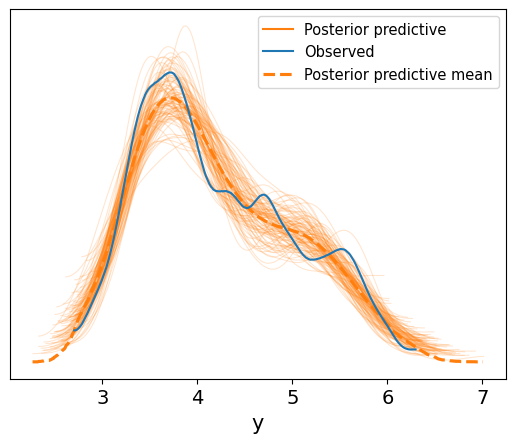

In [10]:
#generate the posterior predictive dist
pm.sample_posterior_predictive(idata_penguin,model_penguin, extend_inferencedata=True)
az.plot_ppc(idata_penguin, num_pp_samples=100, colors=["C1", "C0", "C1"])

In [11]:
posterior_mean = idata_penguin.posterior["μ"]

μ_hdi = az.hdi(ary=idata_penguin, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_penguin, group="posterior_predictive", var_names=["y"]
).T

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


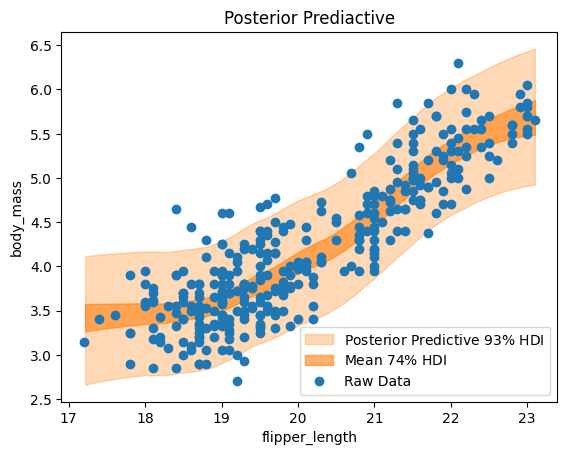

In [12]:
idx = np.argsort(X[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive $93\%$ HDI"},
)

az.plot_hdi(
    x=X[:, 0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)
ax.plot(penguins["flipper_length"], penguins["body_mass"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Prediactive",
    xlabel="flipper_length",
    ylabel="body_mass",
);

**Task8**:

Interpret the plot above in context. Do you think it captures the true association between flipper length and body mass in penguins? Why or why not? Make sure to reference specific things you see in the plot.

array([<Axes: xlabel='X_0'>], dtype=object)

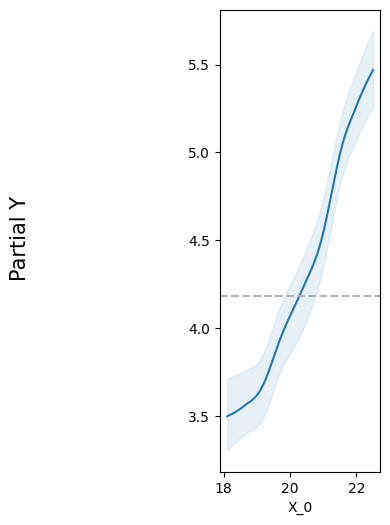

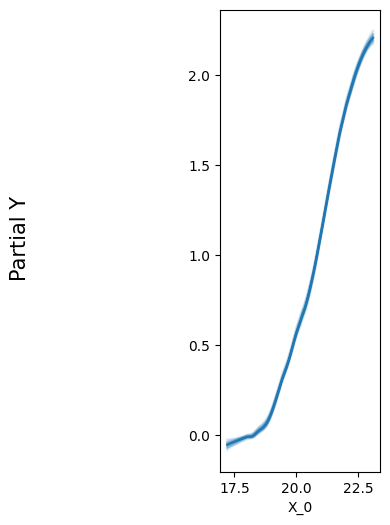

In [14]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))


In [20]:
vi_penguin = pmb.compute_variable_importance(idata_penguinR, μ_, X)
pmb.plot_variable_importance(vi_penguin)

TypeError: object of type 'int' has no len()
Apply node that caused the error: BART_rv{"(m,n),(m),(),(),() -> (m)"}(RNG(<Generator(PCG64) at 0x7B85E681D380>), NoneConst{None}, [[18.1] [1 ... ] [19.8]], [1.3217558 ... .32840038], 50, 0.95, 2.0)
Toposort index: 0
Inputs types: [RandomGeneratorType, <pytensor.tensor.type_other.NoneTypeT object at 0x7b85f322b090>, TensorType(float64, shape=(333, 1)), TensorType(float64, shape=(333,)), TensorType(int8, shape=()), TensorType(float64, shape=()), TensorType(float32, shape=())]
Inputs shapes: ['No shapes', 'No shapes', (333, 1), (333,), (), (), ()]
Inputs strides: ['No strides', 'No strides', (8, 8), (8,), (), (), ()]
Inputs values: [Generator(PCG64) at 0x7B85E681D380, None, 'not shown', 'not shown', array(50, dtype=int8), array(0.95), array(2., dtype=float32)]
Outputs clients: [[], [output[0](μ_)]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-0daca3a91d3e>", line 3, in <cell line: 0>
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
  File "/usr/local/lib/python3.11/dist-packages/pymc_bart/bart.py", line 180, in __new__
    return super().__new__(cls, name, *params, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/pymc/distributions/distribution.py", line 511, in __new__
    rv_out = cls.dist(*args, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/pymc_bart/bart.py", line 184, in dist
    return super().dist(params, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/pymc/distributions/distribution.py", line 580, in dist
    rv_out = cls.rv_op(*dist_params, size=create_size, **kwargs)

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

I think it does a great job of showing the connection between flipper length and body mass since most of the data points fall inside the posterior predictive HDI. This means the model is making solid predictions, following the overall upward trend of both HDIs. It also seems more confident around the average, while less so at the extremes, which you can see from the HDI widening at both ends. The relationship isn’t completely linear either—it curves a bit around flipper lengths of 19 and 21, suggesting that other factors might also be influencing body mass.

**Task9**:

Create partial depnedence plots (pdps), individual conditional expectation (ice) plots, and a variable importance plot for the BARTpenguin model.

**Task10**:

Using the above plots, make an argument about which variable(s) is/are most important in predicting body mass in penguins.

What is the relationship for each variable to body mass, when you take the other variables into account?

Is that relationship complicated by interactions between variables? How do you know?

Make sure to reference specific things you see in each plot, to justify your decisions and comments.

Overall, looking at all three types of graphs, flipper length stands out as the strongest predictor of body mass. The variable importance graph backs this up since it has the highest importance score, meaning it has the biggest impact. The PDP also makes this clear—it shows a mostly linear relationship, making flipper length the most predictable factor. On the other hand, bill length and depth don’t show a clear trend and are mostly nonlinear, so they aren’t as reliable for prediction. The ICE plot for flipper length consistently trends upward, which aligns with the PDP, but the variation in slopes suggests that other factors might also be influencing body mass. Meanwhile, bill length and depth show a lot more variation, reinforcing the idea that they aren’t the best predictors.